Filtering, imputing and summarizing our data set in various ways and so preparing it for distinct ways of modeling.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import readVCF
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import statsmodels.api as sm
import individual_based_analysis as indba
import patsy
import re

## Import and filter

In [2]:
calls = readVCF.readVCFs()
calls = indba.clean_clinical(calls, remove_ancestry=False)

Welcome, Attila Jones!



Number of missing values

In [3]:
len(calls) - calls.count().sort_values()

RAW_MQandDP             3301
InbreedingCoeff         3301
ExcessHet               3301
DS                      3301
END                     3301
POSITIVE_TRAIN_SITE     3251
NEGATIVE_TRAIN_SITE     3238
SiPhyBranchLen          3152
SiPhyLOD                3152
Cluster                  147
Genotyping_Sample_ID     147
EV.5                     147
EV.2                     147
EV.3                     147
EV.1                     147
EV.4                     147
ReadPosRankSum             3
szdbCNVcount               0
GWASpval                   0
Sample                     0
evolConstrain              0
Tissue                     0
Ethnicity                  0
Dx                         0
AntipsychTyp               0
AntipsychAtyp              0
Alcohol                    0
chromatinState_DLPFC       0
ChromatinState_DLPFC       0
CHROM                      0
VQSLOD                     0
POS                        0
REF                        0
ALT                        0
QUAL          

In [4]:
calls = calls.dropna(axis=1)
repr(list(calls.columns))

"['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER/PASS', 'FILTER/HC', 'FILTER/EXT', 'AC', 'AF', 'AN', 'BaseQRankSum', 'DP', 'FS', 'MLEAC', 'MLEAF', 'MQ', 'MQRankSum', 'QD', 'SOR', 'VQSLOD', 'culprit', 'ChromatinState_DLPFC', 'szdbCNVcount', 'GWASpval', 'chromatinState_DLPFC', 'evolConstrain', 'Sample', 'Tissue', 'Ethnicity', 'Dx', 'AntipsychTyp', 'AntipsychAtyp', 'Alcohol', 'Mutation']"

The following columns are clearly redundant.  Remove them! 

In [5]:
calls = calls.drop(columns=['ChromatinState_DLPFC', 'Sample'])

In [6]:
calls.var()

POS              3.074712e+15
QUAL             7.341561e+05
AC               2.063631e+01
AF               8.254522e-03
AN               0.000000e+00
BaseQRankSum     6.585335e+00
DP               7.671930e+03
FS               1.644342e+01
MLEAC            1.989625e+01
MLEAF            7.958500e-03
MQ               1.142095e-04
MQRankSum        2.072671e-02
QD               1.182924e+01
SOR              3.521186e-01
VQSLOD           2.706575e+01
szdbCNVcount     1.680505e+01
GWASpval         5.674950e+00
evolConstrain    4.311347e-02
AntipsychTyp     1.021288e-01
AntipsychAtyp    2.317744e-01
Alcohol          1.653851e-01
dtype: float64

`AN` has zero sample variance.  `MQ` and `MQRankSum` have nearly zero sample variance.  Remove them!

In [7]:
calls = calls.drop(columns=['AN', 'MQ', 'MQRankSum'])

## Correlations between factors

First turn factors to dummy variables and then calculate the correlation matrix.  For simplicity we treat `object` type variables as factors and not binary $\{0, 1\}$ valued categorical variables.

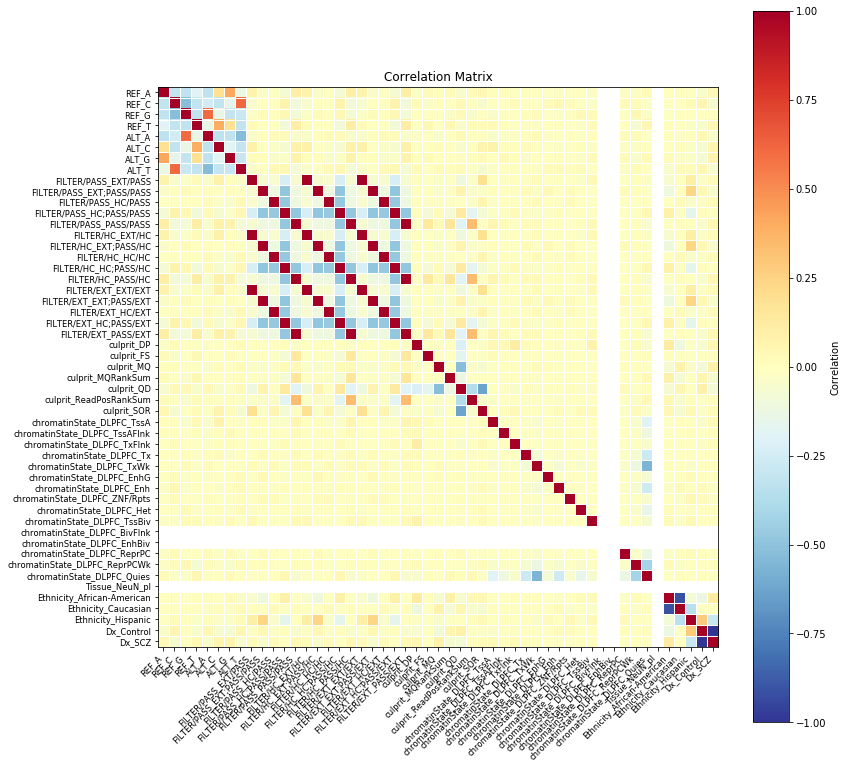

In [8]:
%matplotlib inline
factors = calls.select_dtypes(include=['object', 'category']).drop(columns=['CHROM', 'Mutation'])
dummies = pd.get_dummies(factors)
fig, ax = plt.subplots(figsize=(12,12))
sm.graphics.plot_corr(dummies.corr(), ax=ax, xnames=dummies.columns, ynames=dummies.columns)
cb = plt.colorbar(ax.get_images()[0])
cb.set_label('Correlation')

Remove redundancies!

In [9]:
redundant_vars = ['FILTER/HC', 'FILTER/EXT']
factors = factors.drop(columns=redundant_vars)
cols2drop = np.array([[y for y in dummies.columns if re.match(x + '_.*', y)] for x in redundant_vars]).flatten()
dummies = dummies.drop(columns=cols2drop)

## Correlations between covariates (numeric var)

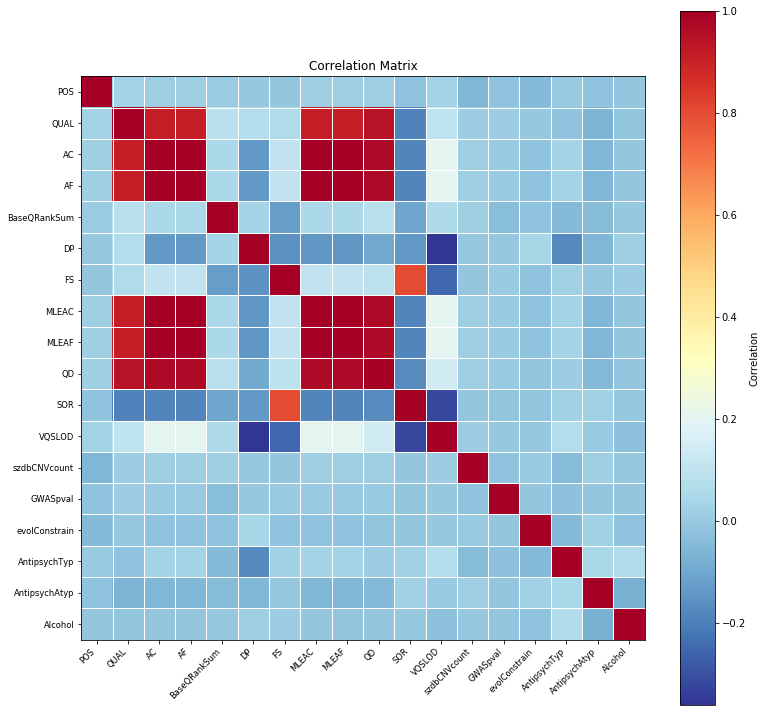

In [10]:
covariates = calls.select_dtypes(exclude=['object', 'category'])
fig, ax = plt.subplots(figsize=(11,11))
sm.graphics.plot_corr(covariates.corr(), ax=ax, xnames=covariates.columns, ynames=covariates.columns)
cb = plt.colorbar(ax.get_images()[0])
cb.set_label('Correlation')

In [11]:
redundant_vars = ['QUAL', 'AC', 'MLEAC', 'MLEAF', 'QD']
covariates = covariates.drop(columns=redundant_vars)

## Correlations between all variables

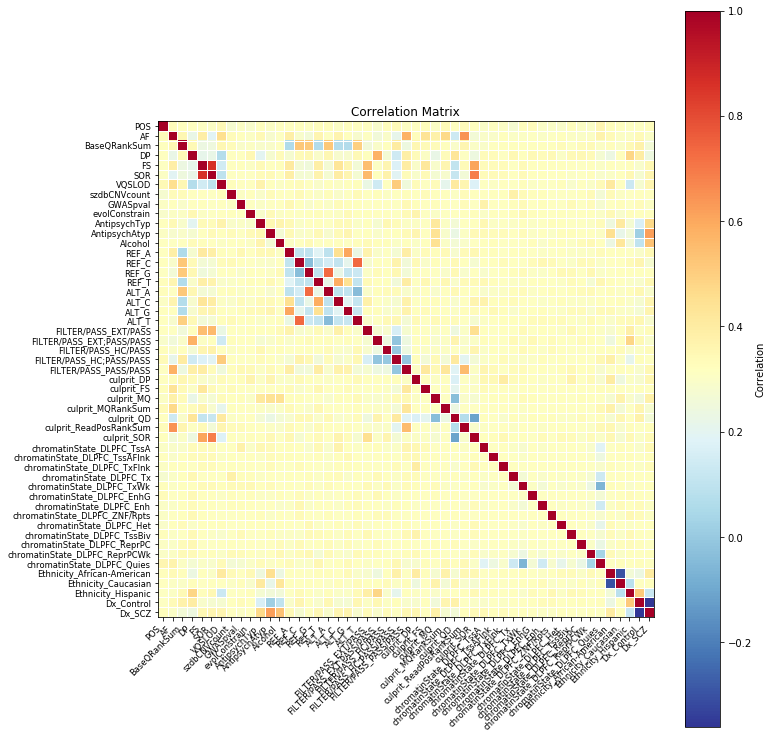

In [12]:
calls_dummy = pd.concat([covariates, dummies], axis=1)
# exclude degenerate variables
calls_dummy = calls_dummy.loc[:, calls_dummy.var(axis=0) != 0]
sm.graphics.plot_corr(calls_dummy.corr(), ax=ax, xnames=calls_dummy.columns, ynames=calls_dummy.columns)

It turns out that `Alcohol` correlates perfectly with ethnicity.  This striking result calls into question the fidelity of the clinical data.

In [13]:
m = calls_dummy.corr()
print(m.loc['Ethnicity_African-American', 'Alcohol'], m.loc['Ethnicity_Caucasian', 'Alcohol'])

-0.12476366854375077 0.1555316829516528


`Alcohol` is chosen to be excluded as this variable is less reliable than `Ethnicity`.

In [14]:
covariates = covariates.drop(columns='Alcohol')

## Putting things together

In [15]:
calls = pd.concat([covariates, factors], axis=1)
calls.columns

Index(['POS', 'AF', 'BaseQRankSum', 'DP', 'FS', 'SOR', 'VQSLOD',
       'szdbCNVcount', 'GWASpval', 'evolConstrain', 'AntipsychTyp',
       'AntipsychAtyp', 'REF', 'ALT', 'FILTER/PASS', 'culprit',
       'chromatinState_DLPFC', 'Tissue', 'Ethnicity', 'Dx'],
      dtype='object')

### Variant based variables

In [16]:
cmc_clinical_path = '/big/results/bsm/2020-08-05-cmc-clinical/CMC_Human_clinical_metadata.csv'
cmc_clinical = pd.read_csv(cmc_clinical_path, index_col='Individual ID')
ancestry_path='/home/attila/projects/bsm/resources/cmc-ancestry/CMC_MSSM-Penn-Pitt_DNA_GENOTYPE_ANCESTRY_GemTools.tsv'
ancestry = pd.read_csv(ancestry_path, sep='\t', index_col='Individual_ID')
variant_based = set(calls.columns) - set(cmc_clinical.columns) - set(ancestry.columns)
variant_based

{'AF',
 'ALT',
 'BaseQRankSum',
 'DP',
 'FILTER/PASS',
 'FS',
 'GWASpval',
 'POS',
 'REF',
 'SOR',
 'Tissue',
 'VQSLOD',
 'chromatinState_DLPFC',
 'culprit',
 'evolConstrain',
 'szdbCNVcount'}

### Individual based variables

In [17]:
individual_based = set(calls.columns) - variant_based
individual_based

{'AntipsychAtyp', 'AntipsychTyp', 'Dx', 'Ethnicity'}

In [18]:
%connect_info

{
  "shell_port": 49579,
  "iopub_port": 40493,
  "stdin_port": 35633,
  "control_port": 40249,
  "hb_port": 49293,
  "ip": "127.0.0.1",
  "key": "13202f30-f995e33d9e32f7826aa28926",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-ec82c0ef-c173-4237-af7b-c493059b4d5e.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
